# Training
This notebook trains the model with 3 fold cross validation.

# Imports and setup

In [1]:
import sys
# Need this to load the packages correc in Fox ml nodes.
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [2]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import wandb

In [3]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [4]:
os.environ['WANDB_NOTEBOOK_NAME'] = '/fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb'
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [5]:
# Function to generate a unique random identifier for experiment tracking.
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


kmyc4k23vc47


In [6]:
# Config for the model
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [7]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [8]:
# Splits the data into train and test. Validation is done using KFold.
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [9]:
priority_df = pd.read_csv("../csv/highest_vs_rest_balanced_jira.csv" , index_col = 0)
priority_df

,text_clean,label,class_original
class,,,
highest,when we do range query on simple keys it does ...,1,Highest
highest,unhandledpromiserejectionwarning unhandled pro...,1,Highest
rest,the fabricunittestdaily branch failing intermi...,0,Medium
rest,as a system operator i want to receive alerts ...,0,Medium
rest,there is no support in datasourcetransactionma...,0,Medium
...,...,...,...
rest,once i have imported a widget into the store i...,0,Low
rest,the spec defines an axiom of a ie singleton li...,0,Medium
rest,to have an history on master of all csvs setup...,0,Medium


In [10]:
# Drop NaN values and reset index of dataframe
priority_df = priority_df[priority_df['text_clean'].notna()]
priority_df = priority_df.rename(columns={'text_clean': 'text'})
priority_df = priority_df.reset_index()
priority_df.drop(columns=["class", "class_original"], inplace=True)

In [11]:
priority_df

,text,label
0,when we do range query on simple keys it does ...,1
1,unhandledpromiserejectionwarning unhandled pro...,1
2,the fabricunittestdaily branch failing intermi...,0
3,as a system operator i want to receive alerts ...,0
4,there is no support in datasourcetransactionma...,0
...,...,...
110711,once i have imported a widget into the store i...,0
110712,the spec defines an axiom of a ie singleton li...,0
110713,to have an history on master of all csvs setup...,0
110714,there are still some changes expected to be me...,1


In [12]:
train_hp_df , test_hp_df = train_test_split(priority_df)

In [13]:
df = train_hp_df

In [14]:
df.reset_index(inplace = True)

In [15]:
df.drop(columns=["index"], inplace=True)

In [16]:
df

,text,label
0,currently we are using usrshareelasticsearch a...,0
1,its been over hrs since the mirror has been up...,0
2,there has been discussion on the mailing lists...,0
3,when elytron client tries to obtain clientconf...,1
4,need to be able to release all items at once v...,1
...,...,...
94103,this was discussed in the pr args will be kept...,0
94104,the take and filter kernels do not currently s...,0
94105,currently pointing to out of date links names ...,1
94106,the chaincode build image relies on accessing ...,1


In [17]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [18]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        15814
       0        15556
1      0        15783
       1        15586
2      0        15685
       1        15684
Name: count, dtype: int64

In [19]:
df

,text,label,kfold
0,currently we are using usrshareelasticsearch a...,0,2
1,its been over hrs since the mirror has been up...,0,0
2,there has been discussion on the mailing lists...,0,0
3,when elytron client tries to obtain clientconf...,1,1
4,need to be able to release all items at once v...,1,2
...,...,...,...
94103,this was discussed in the pr args will be kept...,0,0
94104,the take and filter kernels do not currently s...,0,2
94105,currently pointing to out of date links names ...,1,2
94106,the chaincode build image relies on accessing ...,1,2


In [20]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [21]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [22]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [23]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [24]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [25]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [27]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [28]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [29]:
from codecarbon import track_emissions
@track_emissions()
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [30]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [31]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[codecarbon INFO @ 11:46:24] [setup] RAM Tracking...
[codecarbon INFO @ 11:46:24] [setup] GPU Tracking...
[codecarbon INFO @ 11:46:24] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:46:24] [setup] CPU Tracking...
[codecarbon WARNING @ 11:46:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 11:46:27] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 11:46:27] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 11:46:27] >>> Tracker's metadata:
[codecarbon INFO @ 11:46:27]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 11:46:27]   Python version: 3.11.3
[codecarbon INFO @ 11:46:27]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 11:46:27]   Available RAM : 256.000 GB
[codecarbon INFO @ 11:46:27]   CPU count: 24
[codecarbon INFO @ 11:46:27]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

[INFO] Using GPU: NVIDIA A100-PCIE-40GB



  1%|          | 65/7842 [00:14<22:00,  5.89it/s, Epoch=1, LR=9.63e-6, Train_Loss=0.719][codecarbon INFO @ 11:46:45] Energy consumed for RAM : 0.000400 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 11:46:45] Energy consumed for all GPUs : 0.000734 kWh. Total GPU Power : 176.13753032088954 W
[codecarbon INFO @ 11:46:45] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:46:45] 0.001312 kWh of electricity used since the beginning.
  2%|▏         | 132/7842 [00:29<28:38,  4.49it/s, Epoch=1, LR=8.54e-6, Train_Loss=0.692][codecarbon INFO @ 11:47:00] Energy consumed for RAM : 0.000800 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 11:47:00] Energy consumed for all GPUs : 0.001482 kWh. Total GPU Power : 179.41096693129035 W
[codecarbon INFO @ 11:47:00] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:47:00] 0.002636 kWh of electricity used since the beginning.
  3%|▎         | 199/7842 [00:44<31:16,  4.07it/s, Epoch=

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6929    0.6891    0.6910     15556
          HP     0.6958    0.6996    0.6977     15814

    accuracy                         0.6944     31370
   macro avg     0.6944    0.6943    0.6944     31370
weighted avg     0.6944    0.6944    0.6944     31370

Accuracy = 0.6944
F1_score = 0.6977
Validation Loss Improved (inf ---> 0.5839088480450524)
Model Saved



  0%|          | 28/7842 [00:06<29:00,  4.49it/s, Epoch=2, LR=8.58e-6, Train_Loss=0.552][codecarbon INFO @ 12:20:45] Energy consumed for RAM : 0.054776 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 12:20:45] Energy consumed for all GPUs : 0.117203 kWh. Total GPU Power : 218.34633573829848 W
[codecarbon INFO @ 12:20:45] Energy consumed for all CPUs : 0.024260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:20:45] 0.196238 kWh of electricity used since the beginning.
  1%|          | 96/7842 [00:21<23:40,  5.45it/s, Epoch=2, LR=9.66e-6, Train_Loss=0.581][codecarbon INFO @ 12:21:00] Energy consumed for all GPUs : 0.118066 kWh. Total GPU Power : 207.13469799263112 W
[codecarbon INFO @ 12:21:00] Energy consumed for all CPUs : 0.024437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:21:00] 0.197678 kWh of electricity used since the beginning.
  2%|▏         | 160/7842 [00:36<27:08,  4.72it/s, Epoch=2, LR=1e-5, Train_Loss=0.575]   [codecarbon INFO @ 12:21:15] Energy consumed for RAM : 0.

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7197    0.6567    0.6867     15556
          HP     0.6891    0.7485    0.7175     15814

    accuracy                         0.7029     31370
   macro avg     0.7044    0.7026    0.7021     31370
weighted avg     0.7043    0.7029    0.7023     31370

Accuracy = 0.7029
F1_score = 0.7175
Validation Loss Improved (0.5839088480450524 ---> 0.5729013550384128)
Model Saved



  0%|          | 16/7842 [00:04<38:17,  3.41it/s, Epoch=3, LR=4.11e-6, Train_Loss=0.498][codecarbon INFO @ 12:54:45] Energy consumed for RAM : 0.109151 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 12:54:45] Energy consumed for all GPUs : 0.234196 kWh. Total GPU Power : 224.42230889158046 W
[codecarbon INFO @ 12:54:45] Energy consumed for all CPUs : 0.048342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:54:45] 0.391688 kWh of electricity used since the beginning.
  1%|          | 82/7842 [00:19<31:39,  4.09it/s, Epoch=3, LR=5.95e-6, Train_Loss=0.511][codecarbon INFO @ 12:55:00] Energy consumed for RAM : 0.109551 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 12:55:00] Energy consumed for all GPUs : 0.235067 kWh. Total GPU Power : 209.0922692745624 W
[codecarbon INFO @ 12:55:00] Energy consumed for all CPUs : 0.048519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:55:00] 0.393136 kWh of electricity used since the beginning.
  2%|▏         | 147/7842 [00:34<29:22,  4.37it/s, Epoch=3,

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7213    0.6731    0.6964     15556
          HP     0.6983    0.7442    0.7205     15814

    accuracy                         0.7089     31370
   macro avg     0.7098    0.7086    0.7084     31370
weighted avg     0.7097    0.7089    0.7085     31370

Accuracy = 0.7089
F1_score = 0.7205


[codecarbon INFO @ 13:28:50] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 13:28:50] Energy consumed for RAM : 0.163657 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 13:28:50] Energy consumed for all GPUs : 0.351004 kWh. Total GPU Power : 234.32881811090195 W
[codecarbon INFO @ 13:28:50] Energy consumed for all CPUs : 0.072482 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:28:50] 0.587144 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:28:50] Done!




Training complete in 1h 42m 20s
Best Loss: 0.5729


Train Loss,█▄▁
Valid Accuracy,▁▅█
Valid F1_score,▁▇█
Valid Loss,▆▁█
Best Loss,0.5729
Train Loss,0.51296
Valid Accuracy,0.7089
Valid F1_score,0.7205
Valid Loss,0.58729



====== Fold: 1 ======


[codecarbon INFO @ 13:29:06] [setup] RAM Tracking...
[codecarbon INFO @ 13:29:06] [setup] GPU Tracking...
[codecarbon INFO @ 13:29:06] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:29:06] [setup] CPU Tracking...
[codecarbon WARNING @ 13:29:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 13:29:09] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 13:29:09] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 13:29:09] >>> Tracker's metadata:
[codecarbon INFO @ 13:29:09]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 13:29:09]   Python version: 3.11.3
[codecarbon INFO @ 13:29:09]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 13:29:09]   Available RAM : 256.000 GB
[codecarbon INFO @ 13:29:09]   CPU count: 24
[codecarbon INFO @ 13:29:09]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

[INFO] Using GPU: NVIDIA A100-PCIE-40GB



  1%|          | 64/7842 [00:14<32:02,  4.05it/s, Epoch=1, LR=9.64e-6, Train_Loss=0.717][codecarbon INFO @ 13:29:27] Energy consumed for RAM : 0.000400 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 13:29:27] Energy consumed for all GPUs : 0.000784 kWh. Total GPU Power : 188.2097386315785 W
[codecarbon INFO @ 13:29:27] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:29:27] 0.001362 kWh of electricity used since the beginning.
  2%|▏         | 127/7842 [00:29<33:35,  3.83it/s, Epoch=1, LR=8.64e-6, Train_Loss=0.707][codecarbon INFO @ 13:29:42] Energy consumed for RAM : 0.000800 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 13:29:42] Energy consumed for all GPUs : 0.001606 kWh. Total GPU Power : 197.2658042838907 W
[codecarbon INFO @ 13:29:42] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:29:42] 0.002760 kWh of electricity used since the beginning.
  2%|▏         | 194/7842 [00:44<27:34,  4.62it/s, Epoch=1,

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7360    0.5918    0.6561     15783
          HP     0.6551    0.7851    0.7142     15586

    accuracy                         0.6878     31369
   macro avg     0.6955    0.6884    0.6851     31369
weighted avg     0.6958    0.6878    0.6849     31369

Accuracy = 0.6878
F1_score = 0.7142
Validation Loss Improved (inf ---> 0.5811262316663361)
Model Saved



  1%|          | 51/7842 [00:11<25:00,  5.19it/s, Epoch=2, LR=9.02e-6, Train_Loss=0.592][codecarbon INFO @ 14:03:42] Energy consumed for RAM : 0.055176 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 14:03:42] Energy consumed for all GPUs : 0.116831 kWh. Total GPU Power : 199.12311794031427 W
[codecarbon INFO @ 14:03:42] Energy consumed for all CPUs : 0.024437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:03:42] 0.196443 kWh of electricity used since the beginning.
  2%|▏         | 121/7842 [00:26<29:17,  4.39it/s, Epoch=2, LR=9.88e-6, Train_Loss=0.586][codecarbon INFO @ 14:03:57] Energy consumed for RAM : 0.055575 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 14:03:57] Energy consumed for all GPUs : 0.117661 kWh. Total GPU Power : 199.4821911285179 W
[codecarbon INFO @ 14:03:57] Energy consumed for all CPUs : 0.024614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:03:57] 0.197850 kWh of electricity used since the beginning.
  2%|▏         | 189/7842 [00:41<27:43,  4.60it/s, Epoch=2

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7544    0.5891    0.6616     15783
          HP     0.6595    0.8059    0.7253     15586

    accuracy                         0.6968     31369
   macro avg     0.7069    0.6975    0.6935     31369
weighted avg     0.7072    0.6968    0.6933     31369

Accuracy = 0.6968
F1_score = 0.7253
Validation Loss Improved (0.5811262316663361 ---> 0.5761773109116817)
Model Saved



  0%|          | 7/7842 [00:01<30:11,  4.33it/s, Epoch=3, LR=3.87e-6, Train_Loss=0.406][codecarbon INFO @ 14:37:42] Energy consumed for RAM : 0.109551 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 14:37:42] Energy consumed for all GPUs : 0.232591 kWh. Total GPU Power : 228.98875779390124 W
[codecarbon INFO @ 14:37:42] Energy consumed for all CPUs : 0.048519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:37:42] 0.390661 kWh of electricity used since the beginning.
  1%|          | 73/7842 [00:17<26:35,  4.87it/s, Epoch=3, LR=5.7e-6, Train_Loss=0.541] [codecarbon INFO @ 14:37:57] Energy consumed for RAM : 0.109951 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 14:37:57] Energy consumed for all GPUs : 0.233445 kWh. Total GPU Power : 204.97325154244908 W
[codecarbon INFO @ 14:37:57] Energy consumed for all CPUs : 0.048696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:37:57] 0.392092 kWh of electricity used since the beginning.
  2%|▏         | 136/7842 [00:32<23:27,  5.47it/s, Epoch=3,

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7099    0.7131    0.7115     15783
          HP     0.7082    0.7049    0.7065     15586

    accuracy                         0.7090     31369
   macro avg     0.7090    0.7090    0.7090     31369
weighted avg     0.7090    0.7090    0.7090     31369

Accuracy = 0.709
F1_score = 0.7065
Validation Loss Improved (0.5761773109116817 ---> 0.5626101478520539)


[codecarbon INFO @ 15:11:53] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 15:11:53] Energy consumed for RAM : 0.164221 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 15:11:53] Energy consumed for all GPUs : 0.348597 kWh. Total GPU Power : 231.48212980817917 W
[codecarbon INFO @ 15:11:53] Energy consumed for all CPUs : 0.072732 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:11:53] 0.585550 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:11:53] Done!



Model Saved

Training complete in 1h 42m 41s
Best Loss: 0.5626


Train Loss,█▄▁
Valid Accuracy,▁▄█
Valid F1_score,▄█▁
Valid Loss,█▆▁
Best Loss,0.56261
Train Loss,0.51652
Valid Accuracy,0.709
Valid F1_score,0.7065
Valid Loss,0.56261



====== Fold: 2 ======


[codecarbon INFO @ 15:12:09] [setup] RAM Tracking...
[codecarbon INFO @ 15:12:09] [setup] GPU Tracking...
[codecarbon INFO @ 15:12:09] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:12:09] [setup] CPU Tracking...
[codecarbon WARNING @ 15:12:09] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:12:12] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 15:12:12] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 15:12:12] >>> Tracker's metadata:
[codecarbon INFO @ 15:12:12]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 15:12:12]   Python version: 3.11.3
[codecarbon INFO @ 15:12:12]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 15:12:12]   Available RAM : 256.000 GB
[codecarbon INFO @ 15:12:12]   CPU count: 24
[codecarbon INFO @ 15:12:12]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

[INFO] Using GPU: NVIDIA A100-PCIE-40GB



  1%|          | 65/7842 [00:14<28:31,  4.54it/s, Epoch=1, LR=9.63e-6, Train_Loss=0.699][codecarbon INFO @ 15:12:31] Energy consumed for RAM : 0.000400 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 15:12:31] Energy consumed for all GPUs : 0.000780 kWh. Total GPU Power : 187.03274043287746 W
[codecarbon INFO @ 15:12:31] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:12:31] 0.001357 kWh of electricity used since the beginning.
  2%|▏         | 131/7842 [00:29<23:40,  5.43it/s, Epoch=1, LR=8.56e-6, Train_Loss=0.679][codecarbon INFO @ 15:12:46] Energy consumed for RAM : 0.000800 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 15:12:46] Energy consumed for all GPUs : 0.001584 kWh. Total GPU Power : 193.1070177550953 W
[codecarbon INFO @ 15:12:46] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:12:46] 0.002738 kWh of electricity used since the beginning.
  2%|▏         | 196/7842 [00:44<34:38,  3.68it/s, Epoch=1

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6460    0.8179    0.7218     15685
          HP     0.7518    0.5517    0.6364     15684

    accuracy                         0.6848     31369
   macro avg     0.6989    0.6848    0.6791     31369
weighted avg     0.6989    0.6848    0.6791     31369

Accuracy = 0.6848
F1_score = 0.6364
Validation Loss Improved (inf ---> 0.5816736316490136)
Model Saved



  0%|          | 37/7842 [00:09<30:23,  4.28it/s, Epoch=2, LR=8.76e-6, Train_Loss=0.556][codecarbon INFO @ 15:46:46] Energy consumed for RAM : 0.055176 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 15:46:46] Energy consumed for all GPUs : 0.116925 kWh. Total GPU Power : 210.33917881687853 W
[codecarbon INFO @ 15:46:46] Energy consumed for all CPUs : 0.024437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:46:46] 0.196538 kWh of electricity used since the beginning.
  1%|▏         | 103/7842 [00:24<22:24,  5.76it/s, Epoch=2, LR=9.73e-6, Train_Loss=0.573][codecarbon INFO @ 15:47:01] Energy consumed for RAM : 0.055576 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 15:47:01] Energy consumed for all GPUs : 0.117777 kWh. Total GPU Power : 204.4605066069703 W
[codecarbon INFO @ 15:47:01] Energy consumed for all CPUs : 0.024614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:47:01] 0.197966 kWh of electricity used since the beginning.
  2%|▏         | 161/7842 [00:39<37:17,  3.43it/s, Epoch=2

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6943    0.7395    0.7162     15685
          HP     0.7213    0.6743    0.6970     15684

    accuracy                         0.7069     31369
   macro avg     0.7078    0.7069    0.7066     31369
weighted avg     0.7078    0.7069    0.7066     31369

Accuracy = 0.7069
F1_score = 0.697
Validation Loss Improved (0.5816736316490136 ---> 0.5580680193278281)
Model Saved



  1%|          | 43/7842 [00:09<28:58,  4.49it/s, Epoch=3, LR=4.85e-6, Train_Loss=0.513][codecarbon INFO @ 16:21:01] Energy consumed for RAM : 0.109951 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 16:21:01] Energy consumed for all GPUs : 0.233581 kWh. Total GPU Power : 202.32042614104645 W
[codecarbon INFO @ 16:21:01] Energy consumed for all CPUs : 0.048696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:21:01] 0.392228 kWh of electricity used since the beginning.
  1%|▏         | 111/7842 [00:24<30:05,  4.28it/s, Epoch=3, LR=6.76e-6, Train_Loss=0.5]  [codecarbon INFO @ 16:21:16] Energy consumed for RAM : 0.110351 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 16:21:16] Energy consumed for all GPUs : 0.234435 kWh. Total GPU Power : 205.08846715662565 W
[codecarbon INFO @ 16:21:16] Energy consumed for all CPUs : 0.048873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:21:16] 0.393659 kWh of electricity used since the beginning.
  2%|▏         | 174/7842 [00:39<29:30,  4.33it/s, Epoch=

Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7034    0.7310    0.7169     15685
          HP     0.7200    0.6917    0.7056     15684

    accuracy                         0.7113     31369
   macro avg     0.7117    0.7113    0.7112     31369
weighted avg     0.7117    0.7113    0.7112     31369

Accuracy = 0.7113
F1_score = 0.7056


[codecarbon INFO @ 16:54:58] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 16:54:58] Energy consumed for RAM : 0.164263 kWh. RAM Power : 96.0 W
[codecarbon INFO @ 16:54:58] Energy consumed for all GPUs : 0.349916 kWh. Total GPU Power : 238.43109348707623 W
[codecarbon INFO @ 16:54:58] Energy consumed for all CPUs : 0.072750 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:54:58] 0.586930 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:54:58] Done!




Training complete in 1h 42m 43s
Best Loss: 0.5581


Train Loss,█▄▁
Valid Accuracy,▁▇█
Valid F1_score,▁▇█
Valid Loss,█▁▂
Best Loss,0.55807
Train Loss,0.51379
Valid Accuracy,0.7113
Valid F1_score,0.7056
Valid Loss,0.5603


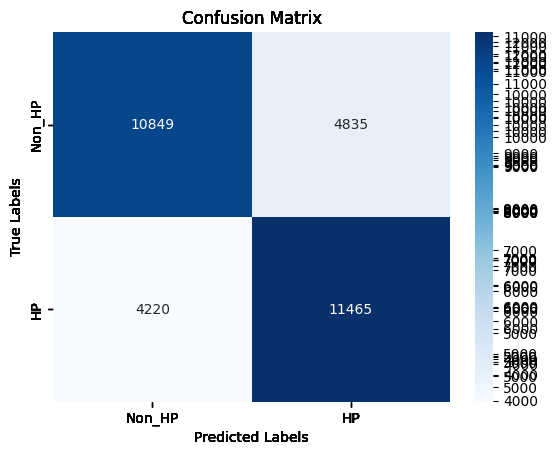

In [32]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [33]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [34]:
test_df = test_hp_df

In [35]:
test_df

,text,label
16484,iiopsecurityinvocationtestcase fails with secu...,0
27086,it seems that we have some jars as part of pdf...,1
51630,release olingo version,0
54583,log cleaner grows buffers when resultmessagesr...,1
59967,hiwith cvs cocoon ive been getting warnings li...,0
...,...,...
76820,error log shows the followingmessage found com...,1
110268,when following the instructions for helloworld...,1
103694,rse server stop over ssh does not work for as ...,1
860,currently there is no way to browse and discov...,0


In [36]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [37]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [38]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [39]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [40]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 1038/1038 [02:15<00:00,  7.68it/s]


Fold 1


100%|██████████| 1038/1038 [02:15<00:00,  7.67it/s]


Fold 2


100%|██████████| 1038/1038 [02:15<00:00,  7.67it/s]


In [41]:
deberta_predictions


[array([[0.27178073, 0.7282193 ],
        [0.11238998, 0.88761   ],
        [0.38828748, 0.6117125 ],
        ...,
        [0.3559289 , 0.64407116],
        [0.93314004, 0.06685997],
        [0.3926115 , 0.60738844]], dtype=float32),
 array([[0.3151631 , 0.68483686],
        [0.05584864, 0.94415134],
        [0.22189075, 0.7781092 ],
        ...,
        [0.3907594 , 0.6092406 ],
        [0.96630424, 0.03369572],
        [0.4112003 , 0.5887997 ]], dtype=float32),
 array([[0.33432955, 0.66567045],
        [0.17477728, 0.8252227 ],
        [0.422705  , 0.57729495],
        ...,
        [0.36321118, 0.6367888 ],
        [0.9270546 , 0.0729454 ],
        [0.37330398, 0.626696  ]], dtype=float32)]

In [42]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.30709115, 0.6929088 ],
       [0.11433864, 0.88566136],
       [0.3442944 , 0.6557056 ],
       ...,
       [0.3699665 , 0.6300335 ],
       [0.9421663 , 0.0578337 ],
       [0.39237192, 0.60762805]], dtype=float32)

In [43]:
len(predictions)

16608

In [44]:
predictions

array([[0.30709115, 0.6929088 ],
       [0.11433864, 0.88566136],
       [0.3442944 , 0.6557056 ],
       ...,
       [0.3699665 , 0.6300335 ],
       [0.9421663 , 0.0578337 ],
       [0.39237192, 0.60762805]], dtype=float32)

In [45]:
test_df["prediction_0"] = predictions[:, 0] 

In [46]:
test_df["prediction_1"] = predictions[:, 1] 

In [47]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [48]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
16484,iiopsecurityinvocationtestcase fails with secu...,0,0.307091,0.692909,1,1,1
27086,it seems that we have some jars as part of pdf...,1,0.114339,0.885661,1,1,1
51630,release olingo version,0,0.344294,0.655706,1,1,1
54583,log cleaner grows buffers when resultmessagesr...,1,0.420403,0.579597,1,1,1
59967,hiwith cvs cocoon ive been getting warnings li...,0,0.598095,0.401905,0,0,0
...,...,...,...,...,...,...,...
76820,error log shows the followingmessage found com...,1,0.556701,0.443299,1,0,1
110268,when following the instructions for helloworld...,1,0.027527,0.972473,1,1,1
103694,rse server stop over ssh does not work for as ...,1,0.369967,0.630033,1,1,1
860,currently there is no way to browse and discov...,0,0.942166,0.057834,0,0,0


In [49]:
len(test_df)

16608

In [50]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [51]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [52]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [53]:
test_df["pred"] = test_df["pred"].astype(int)

In [54]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
16484,iiopsecurityinvocationtestcase fails with secu...,0,0.307091,0.692909,1,1,1,prediction_1,1
27086,it seems that we have some jars as part of pdf...,1,0.114339,0.885661,1,1,1,prediction_1,1
51630,release olingo version,0,0.344294,0.655706,1,1,1,prediction_1,1
54583,log cleaner grows buffers when resultmessagesr...,1,0.420403,0.579597,1,1,1,prediction_1,1
59967,hiwith cvs cocoon ive been getting warnings li...,0,0.598095,0.401905,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
76820,error log shows the followingmessage found com...,1,0.556701,0.443299,1,0,1,prediction_0,0
110268,when following the instructions for helloworld...,1,0.027527,0.972473,1,1,1,prediction_1,1
103694,rse server stop over ssh does not work for as ...,1,0.369967,0.630033,1,1,1,prediction_1,1
860,currently there is no way to browse and discov...,0,0.942166,0.057834,0,0,0,prediction_0,0


In [55]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[5917 2417]
 [2282 5992]]


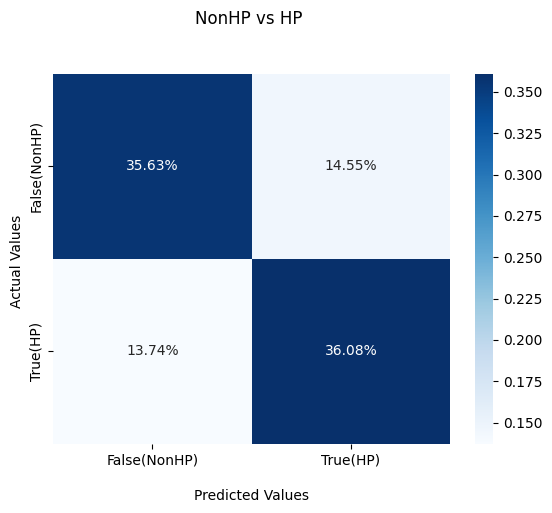

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('NonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [57]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      8334
           1       0.71      0.72      0.72      8274

    accuracy                           0.72     16608
   macro avg       0.72      0.72      0.72     16608
weighted avg       0.72      0.72      0.72     16608

